# Home Credit Default Risk

Source : https://www.kaggle.com/c/home-credit-default-risk/overview 

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Data Description

---application_{train|test}.csv---

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

---bureau.csv---

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

---bureau_balance.csv---

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

---POS_CASH_balance.csv---

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

---credit_card_balance.csv---

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


---previous_application.csv---

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.


---installments_payments.csv---

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


---HomeCredit_columns_description.csv---

This file contains descriptions for the columns in the various data files.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# import preprocessing from sklearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

# featuretools for automated feature engineering
import featuretools as ft

# 1.0 Data Loading

In [3]:
#loading the files

root_path = 'C:/Users/Jitendra Chauhan/Documents/Jitu/UFT/Machine Learning/Final Project/Home_Credit_Default_Risk/data/home-credit-default-risk/'
df_train = pd.read_csv(root_path +'application_train.csv')
df_test = pd.read_csv(root_path +'application_test.csv')
df_prev_app = pd.read_csv(root_path +'previous_application.csv')
df_bureau = pd.read_csv(root_path +'bureau.csv')
df_bureau_bal = pd.read_csv(root_path +'bureau_balance.csv')
df_inst_pay = pd.read_csv(root_path +'installments_payments.csv')
df_credit_card_bal = pd.read_csv(root_path +'credit_card_balance.csv')


print("Shape of Application Train File: ", df_train.shape)
print("Shape of Application Test File: ", df_test.shape)
print("Shape of Previous Application File: ", df_prev_app.shape)
print("Shape of Bureau File: ", df_bureau.shape)
print("Shape of Bureau Balance File: ", df_bureau_bal.shape)
print("Shape of Installments Payment File: ", df_inst_pay.shape)
print("Shape of Credit Card Balance File: ", df_credit_card_bal.shape)

df_train.head()

Shape of Application Train File:  (307511, 122)
Shape of Application Test File:  (48744, 121)
Shape of Previous Application File:  (1670214, 37)
Shape of Bureau File:  (1716428, 17)
Shape of Bureau Balance File:  (27299925, 3)
Shape of Installments Payment File:  (13605401, 8)
Shape of Credit Card Balance File:  (3840312, 23)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# 3.0 Data Merge

In the abovr modules, We have just loaded one csv file i.e application_train.csv and did some data exploration and corelation.

For any machine learning model to perform more accurately, we should take into consideration as much data point as we can.

In this module, we would load other csv files and would merge those records with application_train.csv.


In [4]:
df_merge=pd.merge(df_train, df_bureau,on = 'SK_ID_CURR', how = 'left')
df_merge = pd.merge(df_merge,df_prev_app,on = 'SK_ID_CURR', how = 'left')


df_merge_test=pd.merge(df_test, df_bureau,on = 'SK_ID_CURR', how = 'left')
df_merge_test= pd.merge(df_merge_test,df_prev_app,on = 'SK_ID_CURR', how = 'left')

print("Shape of Application Train File: ", df_train.shape)
print("Shape of Application Test File: ", df_test.shape)
print("Shape of Previous Application File: ", df_prev_app.shape)
print("Shape of Bureau File: ", df_bureau.shape)
print("Train Shape of Merge: ", df_merge.shape)
print("Test Shape of Merge: ", df_merge_test.shape)

Shape of Application Train File:  (307511, 122)
Shape of Application Test File:  (48744, 121)
Shape of Previous Application File:  (1670214, 37)
Shape of Bureau File:  (1716428, 17)
Train Shape of Merge:  (8091522, 174)
Test Shape of Merge:  (1582679, 173)


Understanding the Data Modelling

This a structure relational database. There is one to many relations among these file.

One record of client from application.csv can multiple records in previous_appliction.csv and bureau.csv.
Also, one record of bureau.csv can have multiple records in bureau_balance.csv.

So, as application.csv is our driver table, we would merge data by applying LEFT JOIN bureau.csv, previous_application to application.csv

Primary Key : SK_ID_CURR

In [5]:
# 2.1 Data Engineering

In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# Missing values statistics
missing_values = missing_values_table(df_merge)
missing_values.head(20)

Your selected dataframe has 174 columns.
There are 119 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIVILEGED,8065183,99.7
RATE_INTEREST_PRIMARY,8065183,99.7
AMT_ANNUITY_y,6219242,76.9
COMMONAREA_MODE,5490553,67.9
COMMONAREA_MEDI,5490553,67.9
COMMONAREA_AVG,5490553,67.9
NONLIVINGAPARTMENTS_AVG,5455142,67.4
NONLIVINGAPARTMENTS_MODE,5455142,67.4
NONLIVINGAPARTMENTS_MEDI,5455142,67.4
LIVINGAPARTMENTS_MODE,5366039,66.3


In [8]:
# Number of data type of column
df_merge.dtypes.value_counts()

float64    98
int64      41
object     35
dtype: int64

In [9]:
# Number of unique classes in each object column
df_merge.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE_x             2
CODE_GENDER                      3
FLAG_OWN_CAR                     2
FLAG_OWN_REALTY                  2
NAME_TYPE_SUITE_x                7
NAME_INCOME_TYPE                 8
NAME_EDUCATION_TYPE              5
NAME_FAMILY_STATUS               6
NAME_HOUSING_TYPE                6
OCCUPATION_TYPE                 18
WEEKDAY_APPR_PROCESS_START_x     7
ORGANIZATION_TYPE               58
FONDKAPREMONT_MODE               4
HOUSETYPE_MODE                   3
WALLSMATERIAL_MODE               7
EMERGENCYSTATE_MODE              2
CREDIT_ACTIVE                    4
CREDIT_CURRENCY                  4
CREDIT_TYPE                     15
NAME_CONTRACT_TYPE_y             4
WEEKDAY_APPR_PROCESS_START_y     7
FLAG_LAST_APPL_PER_CONTRACT      2
NAME_CASH_LOAN_PURPOSE          25
NAME_CONTRACT_STATUS             4
NAME_PAYMENT_TYPE                4
CODE_REJECT_REASON               9
NAME_TYPE_SUITE_y                7
NAME_CLIENT_TYPE                 4
NAME_GOODS_CATEGORY 

In [10]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_merge:
    if df_merge[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_merge[col].unique())) <= 2:
            print(col)
            # Train on the training data
            le.fit(df_merge[col])
            # Transform both training and testing data
            df_merge[col] = le.transform(df_merge[col])
            #df_test[col] = le.transform(df_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded in train' % le_count)

le_count_test = 0
for col in df_merge_test:
    if df_merge_test[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_merge_test[col].unique())) <= 2:
            print(col)
            # Train on the training data
            le.fit(df_merge_test[col])
            # Transform both training and testing data
            df_merge_test[col] = le.transform(df_merge_test[col])
            #df_test[col] = le.transform(df_test[col])
            
            # Keep track of how many columns were label encoded
            le_count_test += 1
            
print('%d columns were label encoded in test' % le_count)

NAME_CONTRACT_TYPE_x
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 columns were label encoded in train
NAME_CONTRACT_TYPE_x
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 columns were label encoded in test


In [11]:
#to verify few records 
df_merge.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
2,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
3,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
4,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0


In [12]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [13]:
df_merge, cat_cols = one_hot_encoder(df_merge, True)
df_merge_test, cat_cols = one_hot_encoder(df_merge_test, True)

In [14]:
#verify few records after One hot encoder
df_merge.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,1,0,0
1,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,1,0,0
2,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,1,0,0
3,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,1,0,0
4,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
#to remove some garbage collection. To free up some space
import gc
gc.collect()

40

In [16]:
df_merge_sample = df_merge.sample(frac=0.01)
print(df_merge_sample.shape)

#In order to split the dataset in train and test, we seperate the target variable from other features.

# Here, TARGET is the feature to be predicted

y = df_merge_sample['TARGET']
X = df_merge_sample.drop('TARGET', axis=1) 


(80915, 473)


After merging and one hot encoder, the dataframe became huge. 

The current dataframe is around 8 million records with 462 columns.

It's very difficult to handle this huge dataframe and most of the time the program hangs and fails with Memory exception.

So, we are only considering 1% of the data for our model. 

In [17]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.70, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((24274, 472), (56641, 472), (24274,), (56641,))

# 4.0 Dimension Reduction and Scaling

Let's use Standard Scalar to have all the features at the same scale. Standard Scalar scales all the features so the model doesn't get impacted by some high values features.

PCA is used to anlayse the important features of the dataframe.

In [18]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca=PCA()


In [19]:
#to remove some garbage collection. To free up some space
import gc
gc.collect()

80

In [20]:
# Standard scalar to test and train data

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)



In [21]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [22]:
#Pipeline for standard scalar and PCA
pipeline=make_pipeline (scaler, pca)
pipeline.fit(X_train)
pipeline.fit(X_test)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

Below code to use PCA and get the variance ratio to analyse the important features impacting the dataframe

[0.03868489 0.07298188 0.0939825  0.11370317 0.13186183 0.14821514
 0.16078856 0.17109011 0.18127935 0.19047728 0.19935305 0.2079642
 0.21610981 0.22338646 0.23044556 0.23710964 0.24344249 0.24961628
 0.25563426 0.26151219 0.26719709 0.27265936 0.27791154 0.28307
 0.28815758 0.29317428 0.29809917 0.30296929 0.30775281 0.31245256
 0.317108   0.32167402 0.32616694 0.33054523 0.334769   0.33891986
 0.3429781  0.34698634 0.35093842 0.35477306 0.35857578 0.36236634
 0.36611826 0.36985199 0.37353127 0.37716042 0.38069056 0.38420429
 0.38768195 0.3911415  0.39453415 0.3979144  0.40128383 0.40459893
 0.4078827  0.4111523  0.41441066 0.41764397 0.42086104 0.42404088
 0.42719639 0.43031467 0.4334102  0.43648669 0.43954987 0.4426114
 0.44564983 0.4486831  0.45171297 0.45471519 0.4577003  0.46066517
 0.46362728 0.46658291 0.46953259 0.47247158 0.4753925  0.4783087
 0.48121934 0.4841042  0.48698507 0.48985623 0.49272064 0.49556986
 0.49841823 0.50125801 0.50408066 0.50690064 0.50971313 0.51251356
 

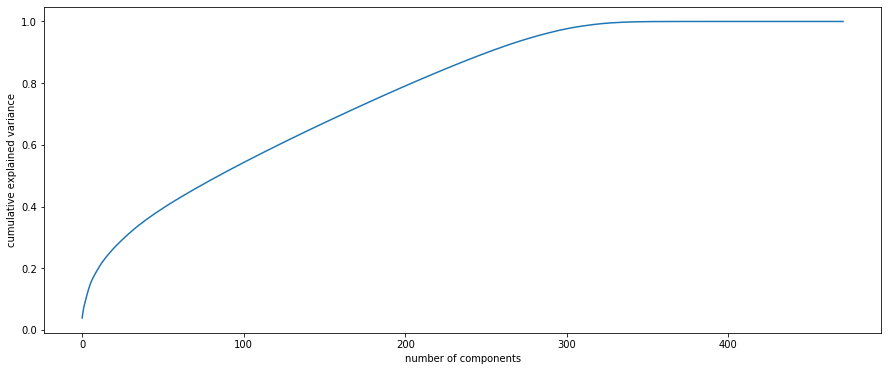

In [23]:
X_train_pca=PCA().fit(X_train)
X_test_pca=PCA().fit_transform(X_test)
plt.figure(figsize=(15,6))
plt.plot(np.cumsum(X_train_pca.explained_variance_ratio_))
print(np.cumsum(X_train_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks()
plt.show()

As per the graph and the list of variance ratio, we can conclude the the number of component ideal from PCA is 330.

Below code we try to fit X_train with hyper parameter 330

In [24]:
pca = PCA(n_components= 330)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
print(X_train_PCA.shape)

(24274, 330)


# 5.0 Model Building

Now we have our dataframe, lets start buildig some model.

I would build Logistic Regression, RandomForest and Support Vector Machine.

And would use Voting Classifier to get the accuracy of each model and find the best one out.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

From above code, all 3 models are initialized. Now let's try to fit our X_train and y_train to the voting classifier.

In [26]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

Now, let's try to get the accuracy from each model

In [27]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("train:",clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train)))
    print("test:",clf.__class__.__name__, accuracy_score(y_test, y_pred))
    print("==================================================================")

train: LogisticRegression 0.9131993079014583
test: LogisticRegression 0.9110538302642962
train: RandomForestClassifier 0.9999588036582352
test: RandomForestClassifier 0.9134902279267668
train: SVC 0.9137348603444014
test: SVC 0.9118659628184531
train: VotingClassifier 0.9176897091538272
test: VotingClassifier 0.9121131335958051


From the above voting classifier, seems like Random Forest would be the best choice model for our dataset

# 5.1 Run the Model

In [28]:
y_pred_rf = rnd_clf.predict(X_test)

# 5.2 Evaluate the model

In [29]:
print(accuracy_score(y_test, y_pred_rf))

0.9134902279267668


After using the predicting our Test data we are getting 91% accuracy from Random Forest model


# 5.3 Grid Search - Random Forest

Lets do the grid search for random forest to get the best estimator.

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':  [5, 10, 25, 50, 100]}]

RF = RandomForestClassifier(random_state=123)

grid_search_RF = GridSearchCV(RF, param_grid, cv=5)
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[

In [31]:
grid_search_RF.best_params_

{'n_estimators': 25}

In [32]:
cvres_RF = grid_search_RF.cv_results_

for mean_score, params in zip(cvres_RF["mean_test_score"], cvres_RF["params"]):
    print(mean_score, params)

0.9067726785861415 {'n_estimators': 5}
0.9134464859520475 {'n_estimators': 10}
0.913858449369696 {'n_estimators': 25}
0.9134876822938123 {'n_estimators': 50}
0.913570074977342 {'n_estimators': 100}


From Grid Search. looks like the best estimator value is 50

In [33]:
selected_model_rf = RandomForestClassifier(n_estimators=25, max_depth=2,random_state=0)
selected_model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
selected_model_rf.score(X_test, y_test)

0.9114952066524249

# 6.0 Light GBM - Best Feature Selection

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[50]	cv_agg's auc: 0.787735 + 0.00538027
[100]	cv_agg's auc: 0.801688 + 0.00539868
[150]	cv_agg's auc: 0.80732 + 0.00631527
[200]	cv_agg's auc: 0.811757 + 0.00630669
[250]	cv_agg's auc: 0.816707 + 0.00694113
[300]	cv_agg's auc: 0.821157 + 0.00607758
[350]	cv_agg's auc: 0.823332 + 0.00617255
[400]	cv_agg's auc: 0.827047 + 0.00630634
[450]	cv_agg's auc: 0.82924 + 0.00572023
[500]	cv_agg's auc: 0.830754 + 0.00605718
[550]	cv_agg's auc: 0.832479 + 0.00598882
[600]	cv_agg's auc: 0.833944 + 0.0061234
Optimum boost rounds = 594
Best CV result = 0.8339881705649625


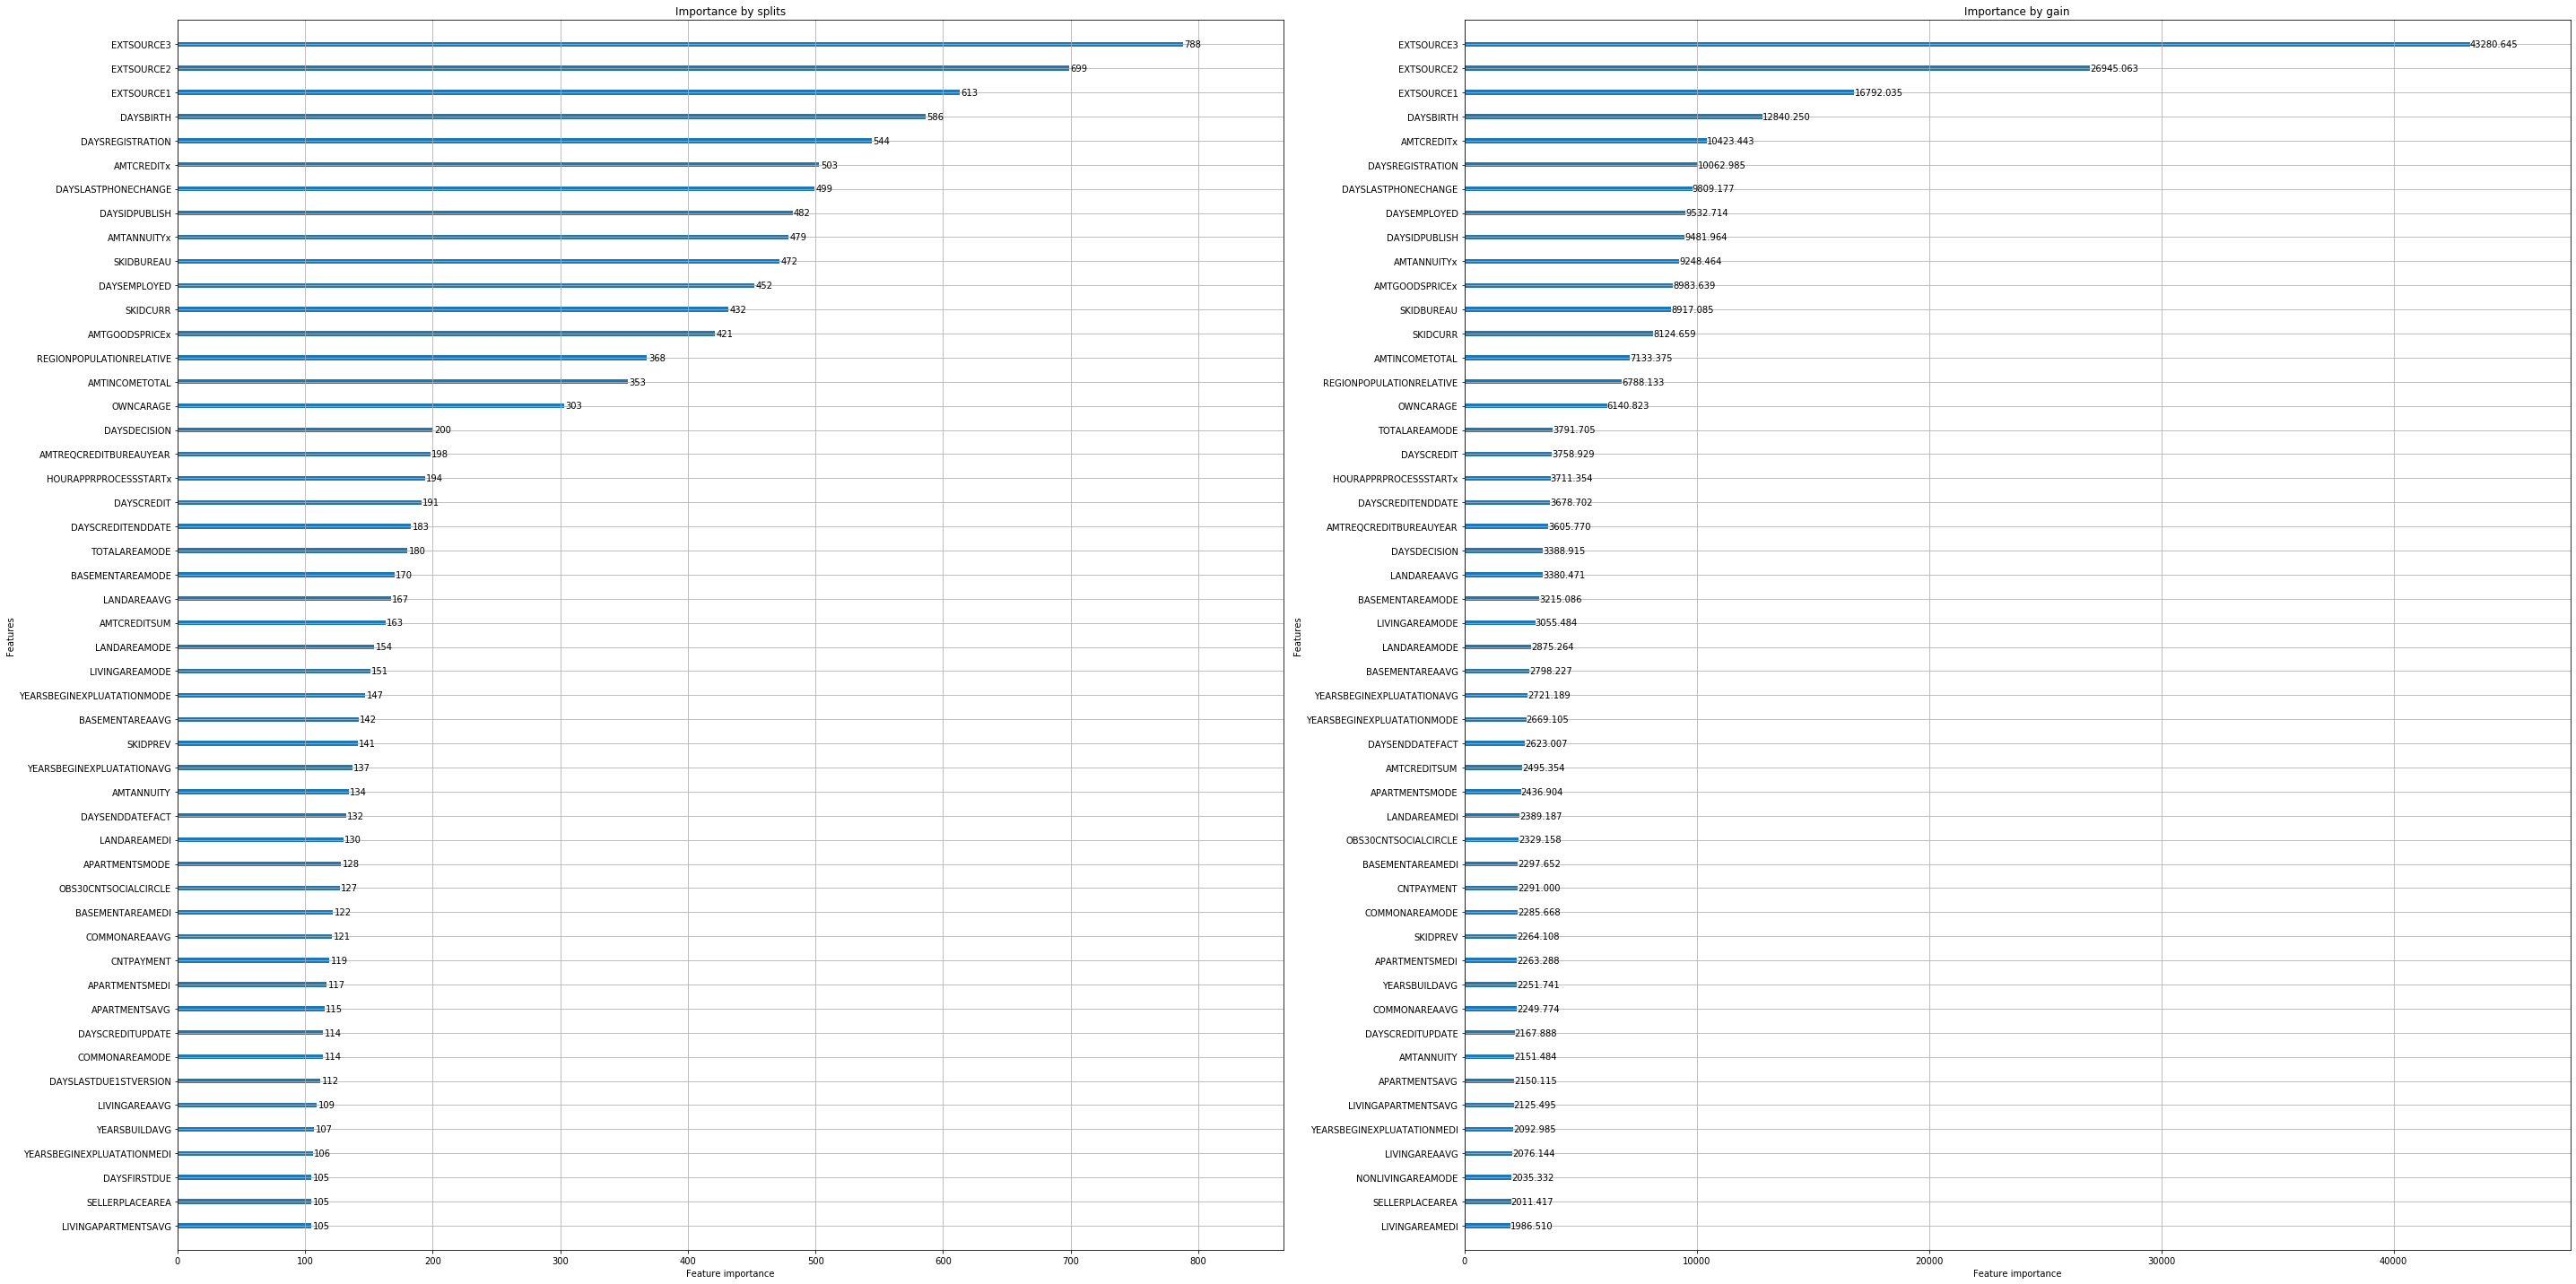

In [37]:
#!pip install lightgbm
import lightgbm as lgbm

""" Train the model """


# Get the features name from X dataframe.
#as the name contains special characters, removing it with below code
feature_names = list(X.columns)
removetable = str.maketrans('', '', ' -:)_+,(/@#%')
feature_names = [s.translate(removetable) for s in feature_names]



#initialize the model
lgbm_train = lgbm.Dataset(data=X,
                          label=y,
                          feature_name = feature_names,
                          free_raw_data=False)
# setting the parameters
lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}

#cross validation with fold=5
cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=600,
                     early_stopping_rounds=50,
                     verbose_eval=50,
                     feature_name = feature_names,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

#test set pred
y_pred = clf.predict(X_test)



fig, (ax, ax1) = plt.subplots(1, 2, figsize=[40, 20])
lgbm.plot_importance(clf, ax=ax, max_num_features=50, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=50, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()